In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from constant import AFFECTNETPATH

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file,base_path,transform=None):
        self.fields = ['subDirectory_filePath', 'expression','valence','arousal']
        self._table = pd.read_csv(csv_file,usecols=self.fields)
        
        self._table=self._table[self._table['expression'] <8]

        self._table=self._table.reset_index(drop=True)

        self._base_path=base_path
   



        self.transform=transforms.Compose([
                     transforms.Resize((32,32)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])

    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path,self._table.subDirectory_filePath[idx])
        img=Image.open(folder_name)
        img=self.transform(img)
        valence = torch.from_numpy(np.array(self._table.valence[idx]))
        return (img,valence.float())
            
        

In [3]:
Affect_Train=ImageDataset('training.csv',AFFECTNETPATH)
Affect_Valid=ImageDataset('validation.csv',AFFECTNETPATH)

In [4]:
import csv
def import_data(filename):
    """Import data in the second column of the supplied filename as floats."""
    with open(filename, 'r') as inf:
        inf.readline()
        return [float(row[2]) for row in csv.reader(inf)]

In [5]:
len(Affect_Train)

287652

In [6]:
train_dataloader = DataLoader(Affect_Train, batch_size=64
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(Affect_Valid, batch_size=64
                       , num_workers=0)    

In [7]:
len(train_dataloader)

4495

In [8]:
Affect_Train[26][0].shape



torch.Size([3, 32, 32])

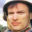

In [9]:
img=transforms.ToPILImage()(Affect_Train[26][0]*0.5+0.5)
img


In [10]:
from module import face_feature

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

model=face_feature.Face_Feature()
model=model.to(device)

In [12]:
device

device(type='cuda', index=0)

In [13]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [14]:
model(Affect_Train[0][0].unsqueeze(0).to(device))

tensor([[0.3613]], grad_fn=<TanhBackward>)

In [15]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, betas=(0.5, 0.999))

In [16]:
from tqdm.notebook import tqdm

In [ ]:
train_loss=[]
val_loss=[]
num_epochs=50

for epochs in (range(0,num_epochs)):
    model.train()
    print("Training Epoch: ", epochs+1,"\n")
   
    for i_batch, (img,valence) in tqdm(enumerate(train_dataloader)):
        batch_size=img.size(0)
        optimizer.zero_grad()
        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        loss=loss1
        loss.backward()
        optimizer.step()
        if i_batch%250==0:
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("MSE loss: ", loss.item())
            train_loss.append(loss.item())
    model.eval()
    avg_loss=1e-6
    temp_loss=0
    for i_batch, (img,valence) in enumerate(valid_dataloader):
        
        batch_size=img.size(0)

        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        #loss2=loss_func(arou_output,valence.to(device))
        loss=loss1
        temp_loss+=loss.item()
    print("ValidationLoss: ",temp_loss/len(valid_dataloader))
    val_loss.append(temp_loss/len(valid_dataloader))
    if temp_loss<avg_loss:
        avg_loss=temp_loss
        torch.save(model,"face_feature.h")
    

    

    
        

Training Epoch:  1 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 4495
MSE loss:  0.2616032361984253
Batch:  251 / 4495
MSE loss:  0.2894498407840729
Batch:  501 / 4495
MSE loss:  0.29474470019340515
Batch:  751 / 4495
MSE loss:  0.2834385633468628
Batch:  1001 / 4495
MSE loss:  0.24670641124248505
Batch:  1251 / 4495
MSE loss:  0.3150092661380768
Batch:  1501 / 4495
MSE loss:  0.29874780774116516
Batch:  1751 / 4495
MSE loss:  0.23826083540916443
Batch:  2001 / 4495
MSE loss:  0.33283182978630066
Batch:  2251 / 4495
MSE loss:  0.2320093959569931
Batch:  2501 / 4495
MSE loss:  0.2953333556652069
Batch:  2751 / 4495
MSE loss:  0.27640900015830994
Batch:  3001 / 4495
MSE loss:  0.29040369391441345
Batch:  3251 / 4495
MSE loss:  0.2682853937149048
Batch:  3501 / 4495
MSE loss:  0.23518404364585876
Batch:  3751 / 4495
MSE loss:  0.2803976833820343
Batch:  4001 / 4495
MSE loss:  0.279130756855011
Batch:  4251 / 4495
MSE loss:  0.2473221719264984


/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



ValidationLoss:  0.3586247061926221
Training Epoch:  2 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 4495
MSE loss:  0.2544076442718506
Batch:  251 / 4495
MSE loss:  0.3091084957122803
Batch:  501 / 4495
MSE loss:  0.2346215844154358
Batch:  751 / 4495
MSE loss:  0.29820215702056885
Batch:  1001 / 4495
MSE loss:  0.2542441487312317
Batch:  1251 / 4495
MSE loss:  0.24393805861473083
Batch:  1501 / 4495
MSE loss:  0.258212685585022
Batch:  1751 / 4495
MSE loss:  0.2889578938484192
Batch:  2001 / 4495
MSE loss:  0.26300787925720215
Batch:  2251 / 4495
MSE loss:  0.2597668766975403
Batch:  2501 / 4495
MSE loss:  0.26610711216926575
Batch:  2751 / 4495
MSE loss:  0.2652439475059509
Batch:  3001 / 4495
MSE loss:  0.22981859743595123
Batch:  3251 / 4495
MSE loss:  0.27491411566734314


In [ ]:
avg_loss=1e6

In [ ]:
avg_loss

In [ ]:
print("hu")